In [69]:
%%capture
!pip install "datasets>=2.18.0,<3" transformers>=4.38.2 sentence-transformers>=2.5.1 setfit>=1.0.3 accelerate>=0.27.2 seqeval>=1.2.2

In [70]:
from datasets import load_dataset

tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes['train'], tomatoes['test']

In [71]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 모델과 토크나이저를 로드합니다.
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
def preprocess_function(examples):
   """입력 데이터를 토큰으로 나눕니다"""
   return tokenizer(examples["text"], truncation=True)

# 훈련 데이터와 테스트 데이터를 토큰화합니다.
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [73]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer =tokenizer)

In [74]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """F1 점수를 계산합니다"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

In [75]:
from transformers import TrainingArguments, Trainer

# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# 훈련 과정을 수행할 Trainer 객체
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [76]:

trainer.train()

Step,Training Loss
500,0.402600


TrainOutput(global_step=534, training_loss=0.39978350950091074, metrics={'train_runtime': 92.1967, 'train_samples_per_second': 92.52, 'train_steps_per_second': 5.792, 'total_flos': 227605451772240.0, 'train_loss': 0.39978350950091074, 'epoch': 1.0})

In [77]:
trainer.evaluate()

{'eval_loss': 0.3659767508506775,
 'eval_f1': 0.8526413345690455,
 'eval_runtime': 5.1971,
 'eval_samples_per_second': 205.116,
 'eval_steps_per_second': 12.892,
 'epoch': 1.0}

In [78]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [80]:
for name, param in model.named_parameters():
  if name.startswith('classifier'):
    param.requires_grad = True
  else:
    param.requires_grad= False

In [81]:
for index, (name, param) in enumerate(model.named_parameters()):
     print(f"{index}: {name} ----- {param.requires_grad}")

0: bert.embeddings.word_embeddings.weight ----- False
1: bert.embeddings.position_embeddings.weight ----- False
2: bert.embeddings.token_type_embeddings.weight ----- False
3: bert.embeddings.LayerNorm.weight ----- False
4: bert.embeddings.LayerNorm.bias ----- False
5: bert.encoder.layer.0.attention.self.query.weight ----- False
6: bert.encoder.layer.0.attention.self.query.bias ----- False
7: bert.encoder.layer.0.attention.self.key.weight ----- False
8: bert.encoder.layer.0.attention.self.key.bias ----- False
9: bert.encoder.layer.0.attention.self.value.weight ----- False
10: bert.encoder.layer.0.attention.self.value.bias ----- False
11: bert.encoder.layer.0.attention.output.dense.weight ----- False
12: bert.encoder.layer.0.attention.output.dense.bias ----- False
13: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
14: bert.encoder.layer.0.attention.output.LayerNorm.bias ----- False
15: bert.encoder.layer.0.intermediate.dense.weight ----- False
16: bert.encoder.layer.0

In [82]:
from transformers import TrainingArguments, Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    processing_class = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)
trainer.train()

Step,Training Loss
500,0.694700


TrainOutput(global_step=534, training_loss=0.6948552721002129, metrics={'train_runtime': 28.0247, 'train_samples_per_second': 304.374, 'train_steps_per_second': 19.055, 'total_flos': 227605451772240.0, 'train_loss': 0.6948552721002129, 'epoch': 1.0})

In [83]:
trainer.evaluate()

{'eval_loss': 0.6825135946273804,
 'eval_f1': 0.64,
 'eval_runtime': 5.0698,
 'eval_samples_per_second': 210.267,
 'eval_steps_per_second': 13.216,
 'epoch': 1.0}

In [84]:

# 모델을 로드합니다.
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 11번째 인코더 블록은 인덱스 165에서 시작합니다.
# 이 블록 이전의 모든 층을 동결합니다.
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# 훈련 과정을 실행할 Trainer 객체를 만듭니다.
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.476100


{'eval_loss': 0.4100644588470459,
 'eval_f1': 0.8072519083969466,
 'eval_runtime': 4.748,
 'eval_samples_per_second': 224.516,
 'eval_steps_per_second': 14.111,
 'epoch': 1.0}

In [85]:
scores = []
for index in range(12):
    # 모델을 다시 로드합니다.
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    # 인코더 블록 0-index를 동결합니다.
    for name, param in model.named_parameters():
        if "layer" in name:
            layer_nr = int(name.split("layer")[1].split(".")[1])
            if layer_nr <= index:
                param.requires_grad = False
        else:
            param.requires_grad = True

    # 모델 훈련
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      processing_class=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
    )
    trainer.train()

    # 평가
    score = trainer.evaluate()["eval_f1"]
    scores.append(score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.405500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.406100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.406600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.408100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.411300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.415100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.421800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.430100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.446200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.472200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.518100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.655600


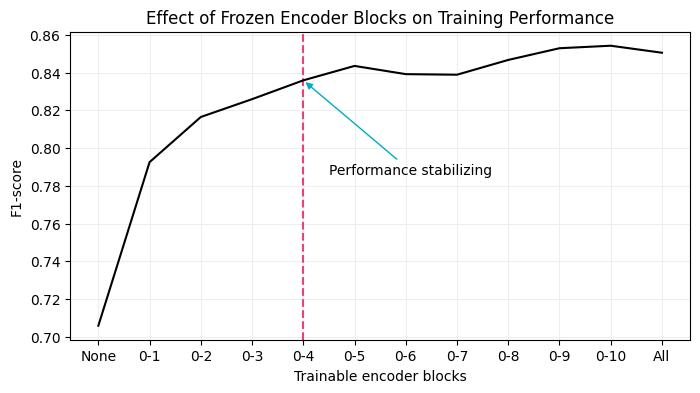

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# 피겨 객체를 만듭니다.
plt.figure(figsize=(8,4))

# 데이터를 준비합니다.
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = scores[::-1]

# 그래프 스타일 설정
plt.grid(color='#ECEFF1')
plt.axvline(x=4, color="#EC407A", linestyle="--")
plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# 그래프를 그립니다.
plt.plot(x, y, color="black")

# 그래프 주석 추가
plt.annotate(
    'Performance stabilizing',
    xy=(4, y[4]),
    xytext=(4.5, y[4]-.05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

In [88]:
import numpy as np
from setfit import sample_dataset

# 퓨-샷 설정을 흉내내기 위해 클래스마다 16개의 샘플을 선택합니다.
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)
sampled_train_data[0]

{'text': 'escapism in its purest form .', 'label': 1}

In [89]:
from setfit import SetFitModel

# 사전 훈련된 SentenceTransformer 모델을 로드합니다.
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [90]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer
import pandas as pd

# 훈련 매개변수를 정의합니다.
args = SetFitTrainingArguments(
    num_epochs=3,      # 대조 학습을 수행할 에포크 횟수
    num_iterations=20  # 생성할 텍스트 쌍 개수
)
args.eval_strategy = args.evaluation_strategy

# Trainer 객체를 만듭니다.
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

AttributeError: 'Column' object has no attribute 'sort'

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
model.model_head

In [91]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# 데이터를 토큰화합니다.
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [93]:
from transformers import DataCollatorForLanguageModeling

# 토큰 마스킹
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [94]:
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator
)

In [95]:
# 사전 훈련된 토크나이저를 저장합니다.
tokenizer.save_pretrained("mlm")

# 모델을 훈련합니다.
trainer.train()

# 업데이트된 모델을 저장합니다.
model.save_pretrained("mlm")

Step,Training Loss
500,2.604200
1000,2.371300
1500,2.306600
2000,2.190800
2500,2.149400
3000,2.089100
3500,2.053200
4000,1.993300
4500,1.986600
5000,1.955400


In [96]:
from transformers import pipeline

# 모델을 로드하고 예측을 만듭니다.
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [97]:
# 모델을 로드하고 예측을 만듭니다.
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Device set to use cuda:0


>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible mess!
>>> What a horrible comedy!
>>> What a horrible story!


In [98]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('mlm',num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('mlm')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mlm and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np

In [102]:
dataset = load_dataset("conll2003", trust_remote_code=True)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'conll2003' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'conll2003' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


RuntimeError: Dataset scripts are no longer supported, but found conll2003.py

In [ ]:
example = dataset["train"][848]
example

In [ ]:
label2id = {
    'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

In [ ]:
from transformers import AutoModelForTokenClassification

# 토크나이저를 로드합니다.
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# 모델을 로드합니다.
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

In [ ]:
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

In [ ]:
def align_labels(examples):
    token_ids = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # 토큰을 해당 단어에 매핑합니다.
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # 새로운 단어의 시작
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # 특수 토큰은 -100
            elif word_idx is None:
                label_ids.append(-100)

            # # 레이블이 B-XXX이면 I-XXX로 바꿉니다.
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

In [ ]:
print(f"원본 레이블: {example['ner_tags']}")
print(f"업데이트된 레이블: {tokenized['train'][848]['labels']}")

In [ ]:
import evaluate

# seqeval을 로드합니다.
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # 예측을 만듭니다.
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # 문서 수준 반복
    for prediction, label in zip(predictions, labels):

      # 토큰 수준 반복
      for token_prediction, token_label in zip(prediction, label):

        # 특수 토큰은 무시합니다.
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

In [ ]:
from transformers import DataCollatorForTokenClassification

# 토큰 분류 DataCollator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
from transformers import pipeline

# Save our fine-tuned model
trainer.save_model("ner_model")

# Run inference on the fine-tuned model
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Maarten.")